# $\S$ 3.3. Subset Selection

Two reasons why we are often not satisfied with the least squares estimates:
1. Prediction accuracy.  
The least squares estimate often have low bias but large variance. Prediction accuracy can sometimes be improved by shrinking or setting some coefficients to zero. By doing so we sacrifice a little bit of bias to reduce the variance of the predicted values, and hence may improve the overall prediction accuracy.
2. Interpretation.  
With a large number of predictiors, we often would like to determine a smaller subset that exhibit the strongest effects. In order to get the "big picture", we are willing to sacrifice some of the small details.

In this section we describe a number of approaches to variable subset selection with linear regression. In later sections we discuss shrinkage and hybrid approaches for controlling variance, as well as other dimension-reduction strategies. These all fall under the general heading model selection. Model selection is not restricted to linear models; Chapter 7 covers this topic in some detail.

With subset selection we retain only a subset of the variables, and eliminate the rest from the model. Least squares regression is used to estimate the coefficients of the inputs that are retained. There are a number of different strategies for choosing the subset.

## $\S$ 3.3.1. Best-Subset Selection

Best subset regression finds for each $k\in\lbrace0,1,2,\cdots,p\rbrace$ the subset of size $k$ that gives the smallest residual sum of squares. An efficient algorithm -- the *leaps and bounds* procedure (Furnival and Wilson, 1974) -- makes this feasible for $p$ as large as 30 or 40.

In [1]:
"""FIGURE 3.5. All possible subset models for the prostate cancer example

At each subset size is shown the residual sum-of-squares for each model of
that size."""
import math
import collections
import itertools
import functools
import operator as op

import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/prostate/prostate.data', delimiter='\t',
                   index_col=0)
data_y = data['lpsa']
data_x_normalized = data.drop(['train', 'lpsa'], axis=1)\
                        .apply(scipy.stats.zscore)
# data_normalized.describe()  # check it normalized!

data_x_train = data_x_normalized[data['train'] == 'T']
data_y_train = data_y[data['train'] == 'T']
data_x_test = data_x_normalized[data['train'] == 'F']
data_y_test = data_y[data['train'] == 'F']
vec_y = data_y_train.as_matrix()
vec_y_test = data_y_test.as_matrix()

size_train = sum(data['train'] == 'T')
size_test = sum(data['train'] == 'F')
size_predictor = len(data_x_train.columns)

In [7]:
def ols_with_column_names(df_x:pd.DataFrame, vec_y:scipy.ndarray,
                          *column_names) ->float:
    if column_names:
        df_x_subset = df_x[list(column_names)]
        mat_x = scipy.hstack((scipy.ones((len(df_x), 1)),
                           df_x_subset.as_matrix()))
    else:
        mat_x = scipy.ones((len(df_x), 1))
    ols_beta = scipy.linalg.solve(mat_x.T @ mat_x, mat_x.T @ vec_y)
    vec_y_fitted = mat_x @ ols_beta
    return ols_beta, vec_y_fitted

In [4]:
def ncr(n:int, r:int) ->int:
    """Compute combination number nCr"""
    r = min(r, n-r)
    if r == 0:
        return 1
    numer = functools.reduce(op.mul, range(n, n-r, -1))
    denom = functools.reduce(op.mul, range(1, r+1))
    return numer//denom


def ols_with_subset_size(df_x:pd.DataFrame, vec_y:scipy.ndarray,
                         k:int) ->scipy.ndarray:
    if k == 0:
        ols_beta, vec_y_fitted = ols_with_column_names(df_x, vec_y)
        return [{
            'column_names': 'constant',
            'beta': ols_beta,
            'rss': ((vec_y-vec_y_fitted)**2).sum(),
        }]
    column_combi = itertools.combinations(data_x_normalized.columns, k)
    result = []
    for column_names in column_combi:
        ols_beta, vec_y_fitted = ols_with_column_names(df_x, vec_y,
                                                       *column_names)
        result.append({
            'column_names': column_names,
            'beta': ols_beta,
            'rss': ((vec_y-vec_y_fitted)**2).sum(),
        })
    return result

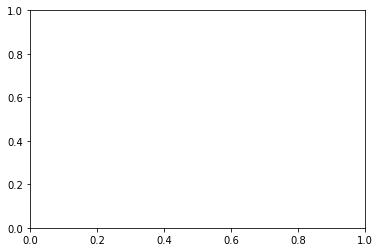

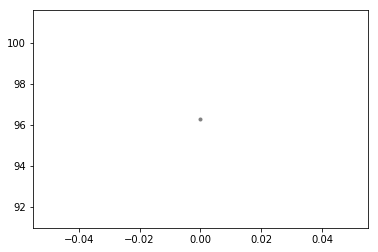

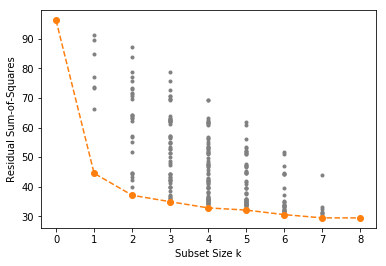

In [8]:
fig35 = plt.figure()
ax = fig35.add_subplot(1, 1, 1)

rss_min = []
for k in range(size_predictor+1):
    number_of_combinations = ncr(size_predictor, k)
    ols_list = ols_with_subset_size(data_x_train, vec_y, k)
    ax.plot(scipy.ones(number_of_combinations)*k, [d['rss'] for d in ols_list],
            'o', color='gray', markersize=3)
    ols_best = min(ols_list, key=op.itemgetter('rss'))
    rss_min.append(ols_best['rss'])
ax.plot(range(size_predictor+1), rss_min, 'o--', color='C1')
ax.set_xlabel('Subset Size k')
ax.set_ylabel('Residual Sum-of-Squares')
plt.show()

Note that the best subset of size 2, for example, need not include the variable that was in the best subset if size 1. The best-subset curve is necessarily decreasing, so cannot be used to select the subsit size $k$. The question of how to choose $k$ involves the tradeoff between bias and variance, along with more subjective desire for parsimony. There are a number of criteria that one may use; typically we choose the smallest model that minimizes an estimate of the expected prediction error.

Many of the other approaches that we discuss in this chapter are similar, in that they use the training data to produce a sequence of models varying in complexity and indexed by a single parameter. In the next section we use cross-validation to estimate prediction error and select $k$; the $\text{AIC}$ criterion is a popular alternative.

## $\S$ 3.3.2. Forward- and Backward-Stepwise Selection

> Rather than search through all possible subsets, we can seek a good path through them.

### Forward-stepwise selection

*Forward-stepwise selection* starts with the intercept, and the sequentially adds into the model the predictor that most improves the fit. Clever updating algorithms can exploit the QR decomposition for the current fit to rapidly establish the next candidate. Like best-subset regression, the subset size $k$ mush be determined.

Forward-stepwise selection is a *greedy algorithm*, producing a nested sequence of models. In this sense it might seem sub-optimal compared to best-subset selection. However, there are several reasons why it might be preferred:
* Computational; we can always compute the forward stepwise sequence (even when $p \gg N$).
* Statistical;forward stepwise is a more constrained search than the best subset selection, and will have lower variance, but perhaps more bias.

### Backward-stepwise selction

*Backward-stepwise selection* starts with the full model, and sequentially deletes the predictor that has the least impact on the fit. The candidate for dropping is the variable with the smallest Z-score. Backward selection can only be used when $N>p$, while forward selection can always be used.

On the prostate cancer example, best-subset, forward and backward selection all gave exactly the same sequence of terms.

In [6]:
"""FIGURE 3.6. Comparison of four subset-selection techniques on a
simulated linear regression problem Y = X^T * beta + epsilon"""
print('NOT YET IMPLEMENTED')

NOT YET IMPLEMENTED


## $\S$ 3.3.3. Forward-Stagewise Regression

See the textbook.

## $\S$ 3.3.4. Prostate Cancer Data Example (Continued)

With subset size $k$ determined via tenfold cross-validation, best-subset selection chose to use the two predictors $\texttt{lcvol}$ and $\texttt{lweight}$.

### Cross-validation, briefly

1. Cross-validation works by dividing the training data randomly into ten equal parts.
2. The learning method is fit -- for a range of values of the complexity parameter -- to nine-tenths of the data.
3. The prediction error is computed on the remaining one-tenth.
4. Repeat step 2 - step 3 for each one-tenth of the data, and the ten prediction error estimates are averaged.
5. Then we obtain an estimated prediction error curve as a function of the complexity parameter so that a proper complexity parameter can be chosen.

We have used the "one-standard-error" rule -- we pick the most parsimonious model within one standard error of the minimun. Such a rule acknowledges the fact that the tradeoff curve is estimated with error, and hence takes a conservative approach.

In [9]:
"""FIGURE 3.7. Estimated prediction error curves and their standard errors
for the best-subset selection via tenfold cross-validation.

Unfortunately, the result of this code does not agree with the textbook. It
is suspected that the scheme to split the trainig data for CV has an issue,
or the stderr of CV error may be wrongly calculated."""
def index_tenfold(n:int) ->scipy.ndarray:
    """Produce index array for tenfold CV with dataframe length n."""
    original_indices = scipy.arange(n)
    tenfold_indices = scipy.zeros(n)

    div, mod = divmod(n, 10)
    unit_sizes = [div for _ in range(10)]
    for i in range(mod):
        unit_sizes[i] += 1

    for k, unit_size in enumerate(unit_sizes):
        tenfold = scipy.random.choice(original_indices, unit_size,
                                   replace=False)
        tenfold_indices[tenfold] = k
        original_indices = scipy.delete(
            original_indices,
            [scipy.argwhere(original_indices == val) for val in tenfold],
        )
        # print(tenfold, original_indices)
    return tenfold_indices

In [10]:
indices_tenfold = index_tenfold(size_train)
cv_results = collections.defaultdict(list)

for cv in range(10):
    mask_cv = indices_tenfold != cv
    size_cv_train = sum(mask_cv == True)

    df_x = data_x_train[mask_cv]
    v_y = vec_y[mask_cv]
    
    for k in range(size_predictor+1):
        ols = ols_with_subset_size(df_x, v_y, k)
        ols_best = min(ols, key=op.itemgetter('rss'))
        cv_results[k].append(ols_best['rss']/size_cv_train)

rss_average = [sum(rss)/10 for _, rss in cv_results.items()]
rss_stderr = [math.sqrt((sum(scipy.array(rss)**2)-10*rss_average[k]**2)/9)
              for k, rss in cv_results.items()]

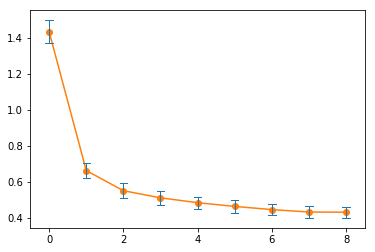

In [11]:
fig37 = plt.figure()
ax = fig37.add_subplot(1, 1, 1)
ax.plot(list(cv_results.keys()), rss_average, 'o-', color='C1')
for k, (ave, stderr) in enumerate(zip(rss_average, rss_stderr)):
    ax.plot([k, k], [ave-stderr, ave+stderr], color='C0', linewidth=1)
    ax.plot([k-.1, k+.1], [ave-stderr, ave-stderr], color='C0', linewidth=1)
    ax.plot([k-.1, k+.1], [ave+stderr, ave+stderr], color='C0', linewidth=1)
plt.show()

In [13]:
"""Table 3.3. Estimated coefficients ad test error result for the
best-subset selection applied to the prostate data

Even though the above CV does not select k = 2, we take k = 2 anyway as the
book does. Also I couldn't figure out where the Std Error = 0.143 comes
from.
"""
ols_k2 = ols_with_subset_size(data_x_train, vec_y, k=2)
ols_k2_best = min(ols_k2, key=op.itemgetter('rss'))

df_x_test = data_x_test[list(ols_k2_best['column_names'])]
mat_x_test = scipy.hstack((scipy.ones((size_test, 1)), df_x_test.as_matrix()))
vec_y_test_fitted = mat_x_test @ ols_k2_best['beta']

print('{0:>15} {1:>15}'.format('Term', 'Best Subset'))
print('-'*31)
print('{0:>15} {1:>15.3f}'.format('Intercept', ols_k2_best['beta'][0]))
for idx, col_name in enumerate(ols_k2_best['column_names']):
    print('{0:>15} {1:>15.3f}'.format(col_name, ols_k2_best['beta'][idx+1]))
print('-'*31)
print('{0:>15} {1:>15.3f}'.format(
    'Test Error',
    sum((vec_y_test-vec_y_test_fitted)**2)/size_test),
)

           Term     Best Subset
-------------------------------
      Intercept           2.477
         lcavol           0.736
        lweight           0.315
-------------------------------
     Test Error           0.492
